# Multivariate Forecasting

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from ts.data.dataset import AmazonStockPrice
from ts.utility import Utility
from ts.plot import Plot

%matplotlib inline

In [2]:
stock_df = AmazonStockPrice.loadData('/Users/ahmed/Downloads/Datasets/amazonStockPrice')
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [3]:
column_names = list(stock_df.columns)

for column_name in column_names:
    print(column_name, stock_df[column_name].dtype)

Date datetime64[ns]
Open float64
High float64
Low float64
Close float64
Adj Close float64
Volume int64


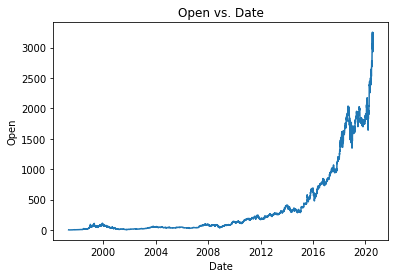

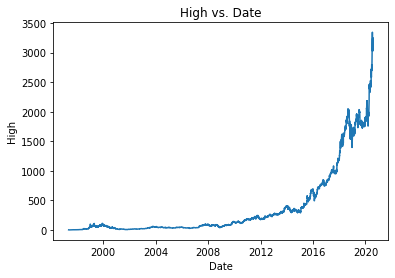

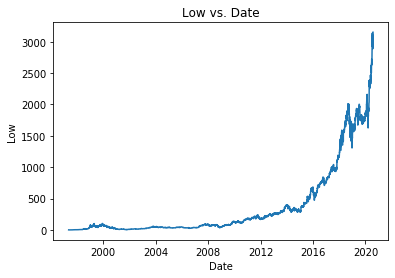

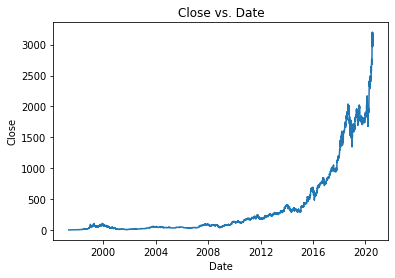

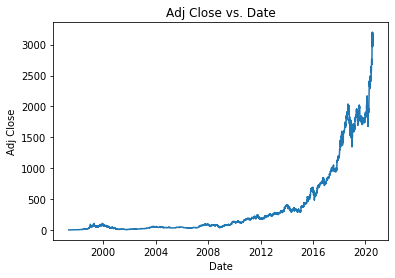

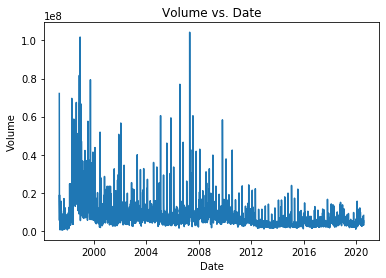

In [4]:
# Plotting the columns with respect to time

for column_name in column_names:
    if column_name == 'Date':
        continue
        
    plt.plot(stock_df['Date'].to_numpy(), stock_df[column_name].to_numpy())
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.title(f'{column_name} vs. Date')
    plt.show()

In [5]:
# Converting data into the format accepted the model

# Since volume data doesn't seem to follow a pattern, we
# may discard it for now. We also discard the date
data = stock_df \
    .drop(columns=['Date', 'Volume']) \
    .to_numpy()

print(f'Shape: {data.shape}, Type: {data.dtype}')
print('First 5 rows: \n', data[:5])

Shape: (5842, 5), Type: float64
First 5 rows: 
 [[2.4375     2.5        1.92708337 1.95833337 1.95833337]
 [1.96875    1.97916663 1.70833337 1.72916663 1.72916663]
 [1.76041663 1.77083337 1.625      1.70833337 1.70833337]
 [1.72916663 1.75       1.63541663 1.63541663 1.63541663]
 [1.63541663 1.64583337 1.375      1.42708337 1.42708337]]


In [6]:
# train-test split

trainSize = 4842
dataTrain, dataTest = Utility.trainTestSplit(data, train=trainSize)

In [7]:
# Convert Long Training Dataset into multiple smaller
# training datasets

seqLength = 500

trainSequences = Utility.breakTrainSeq(
    targetSeries=dataTrain,
    exogenousSeries=None,
    seqLength=seqLength
)

# MLP model

In [8]:
from ts.model import DeepNN

Epoch 1/40
10/10 [==============================] - 0s 3ms/step - loss: 72109.3047
Epoch 2/40
10/10 [==============================] - 0s 3ms/step - loss: 29582.6348
Epoch 3/40
10/10 [==============================] - 0s 3ms/step - loss: 15931.7969
Epoch 4/40
10/10 [==============================] - 0s 2ms/step - loss: 7085.9141
Epoch 5/40
10/10 [==============================] - 0s 2ms/step - loss: 3809.4932
Epoch 6/40
10/10 [==============================] - 0s 3ms/step - loss: 1273.9143
Epoch 7/40
10/10 [==============================] - 0s 3ms/step - loss: 326.6843
Epoch 8/40
10/10 [==============================] - 0s 3ms/step - loss: 136.1421
Epoch 9/40
10/10 [==============================] - 0s 3ms/step - loss: 92.8828
Epoch 10/40
10/10 [==============================] - 0s 2ms/step - loss: 106.5401
Epoch 11/40
10/10 [==============================] - 0s 3ms/step - loss: 101.7063
Epoch 12/40
10/10 [==============================] - 0s 2ms/step - loss: 98.6145
Epoch 13/40
10/10 

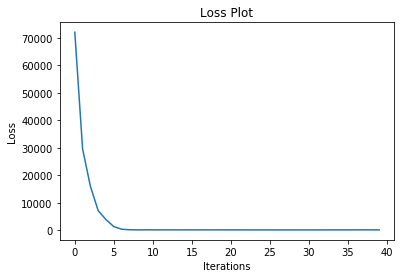

In [9]:
# Model Hyperparameters
forecastHorizon = 1
lag = 10
activation = 'relu'
numUnitsPerLayer = 20
numLayers = 2
numTargetVariables = dataTrain.shape[1]
numExoVariables = 0

# Training Hyperparameters
numIterations = 40
optimizer = tf.optimizers.Adam()

model = DeepNN(
    forecastHorizon=forecastHorizon,
    lag=lag,
    activation=activation,
    numUnitsPerLayer=numUnitsPerLayer,
    numLayers=numLayers,
    numTargetVariables=numTargetVariables,
    numExoVariables=numExoVariables
)

losses = model.train(
    trainSequences=trainSequences,
    numIterations=numIterations,
    optimizer=optimizer
)

Plot.plotLoss(losses)

In [10]:
loss, pred = model.evaluate(
    targetSeries=dataTest,
    returnPred=True
)

target = dataTest[forecastHorizon + lag:, :]

print(f'Loss on Test Set: {loss}')

Loss on Test Set: 3321.1028419189547


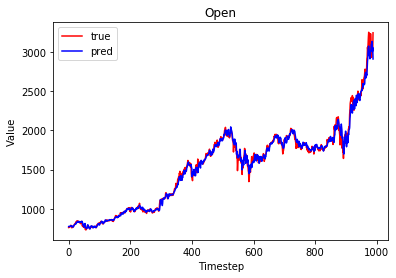

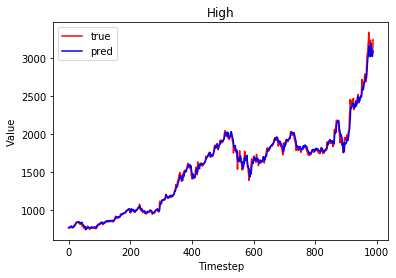

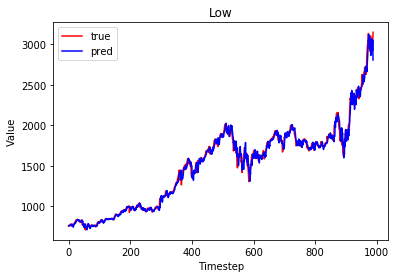

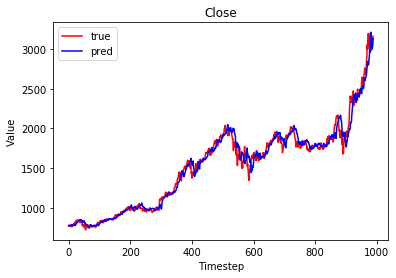

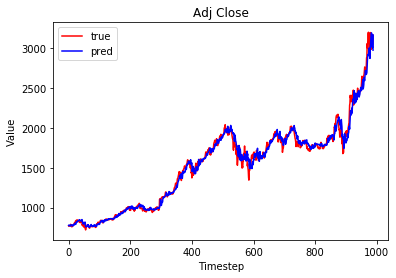

In [11]:
columnNames = filter(
    lambda columnName : columnName != 'Date' and columnName != 'Volume',
    list(stock_df.columns)
)

for i, columnName in enumerate(columnNames):
    Plot.plotPredTrue(
        pred=pred[:, i],
        target=target[:, i],
        title=columnName
    )

# LSTM model

In [12]:
from ts.model import LstmForecast

Epoch 1/10
10/10 [==============================] - 2s 173ms/step - loss: 51020.4766
Epoch 2/10
10/10 [==============================] - 2s 166ms/step - loss: 48495.1602
Epoch 3/10
10/10 [==============================] - 2s 171ms/step - loss: 45690.2578
Epoch 4/10
10/10 [==============================] - 2s 167ms/step - loss: 43015.1328
Epoch 5/10
10/10 [==============================] - 2s 165ms/step - loss: 41643.4102
Epoch 6/10
10/10 [==============================] - 2s 167ms/step - loss: 39720.3672
Epoch 7/10
10/10 [==============================] - 2s 164ms/step - loss: 38463.5078
Epoch 8/10
10/10 [==============================] - 2s 164ms/step - loss: 37066.5859
Epoch 9/10
10/10 [==============================] - 2s 163ms/step - loss: 36233.5859
Epoch 10/10
10/10 [==============================] - 2s 163ms/step - loss: 35123.9922


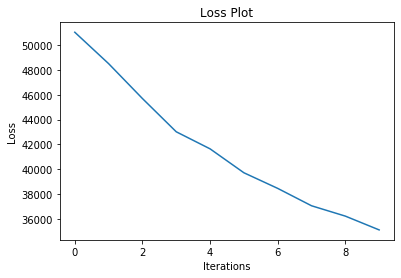

In [13]:
# Model Hyperparameters
forecastHorizon = 1
stateSize = 50
numRnnLayers = 2
numTargetVariables = dataTrain.shape[1]
numExoVariables = 0

# Training Hyperparameters
numIterations = 10
optimizer = tf.optimizers.Adam(0.05)

model = LstmForecast(
    forecastHorizon=forecastHorizon,
    stateSize=stateSize,
    numRnnLayers=numRnnLayers,
    numTargetVariables=numTargetVariables,
    numExoVariables=numExoVariables
)

model.model.build((None, None, numTargetVariables + numExoVariables))

losses = model.train(
    trainSequences=trainSequences,
    numIterations=numIterations,
    optimizer=optimizer
)

Plot.plotLoss(losses)

In [14]:
loss, pred = model.evaluate(
    targetSeries=dataTest,
    returnPred=True
)

target = dataTest[forecastHorizon:, :]

print(f'Loss on Test Set: {loss}')

Loss on Test Set: 2342600.0


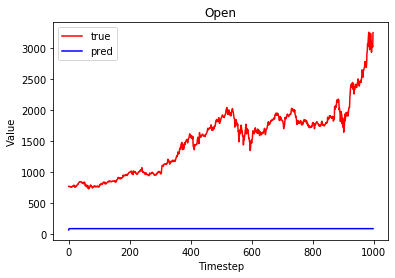

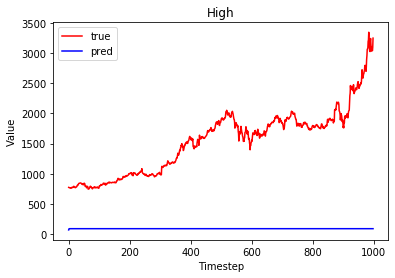

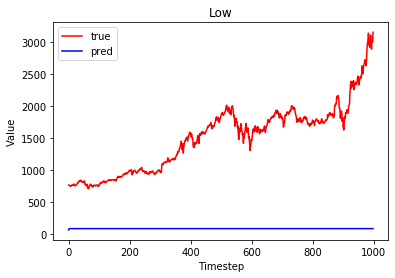

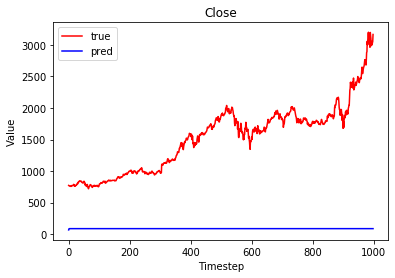

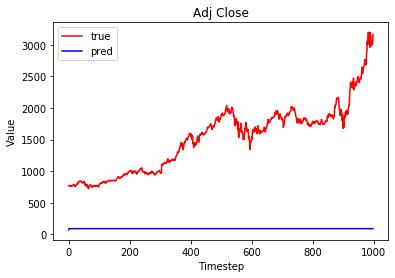

In [15]:
columnNames = filter(
    lambda columnName : columnName != 'Date' and columnName != 'Volume',
    list(stock_df.columns)
)

for i, columnName in enumerate(columnNames):
    Plot.plotPredTrue(
        pred=pred[:, i],
        target=target[:, i],
        title=columnName
    )

# Univariate Forecasting

In [16]:
# Converting data into the format accepted the model

# Since volume data doesn't seem to follow a pattern, we
# may discard it for now. We also discard the date
updated_df = stock_df.drop(columns=['Date', 'Volume'])

# Let's predict the opening price
predColumn = 'Open'
exoColumns = filter(
    lambda columnName : columnName != 'Open', 
    list(updated_df.columns)
)

# Get target and exogenous series
targetSeries = np.expand_dims(updated_df['Open'].to_numpy(), axis=1)
exogenousSeries = updated_df[exoColumns].to_numpy()

# printing the shapes
print(f'Target Series: Shape: {targetSeries.shape}, Datatype: {targetSeries.dtype}')
print(f'Exogenous Series: Shape: {exogenousSeries.shape}, Datatype: {exogenousSeries.dtype}')

Target Series: Shape: (5842, 1), Datatype: float64
Exogenous Series: Shape: (5842, 4), Datatype: float64


In [17]:
# Print few data rows

print('Target Series top 5 rows: \n', targetSeries[:5])
print('Exogenous Series top 5 rows: \n', exogenousSeries[:5])

Target Series top 5 rows: 
 [[2.4375    ]
 [1.96875   ]
 [1.76041663]
 [1.72916663]
 [1.63541663]]
Exogenous Series top 5 rows: 
 [[2.5        1.92708337 1.95833337 1.95833337]
 [1.97916663 1.70833337 1.72916663 1.72916663]
 [1.77083337 1.625      1.70833337 1.70833337]
 [1.75       1.63541663 1.63541663 1.63541663]
 [1.64583337 1.375      1.42708337 1.42708337]]


In [18]:
# train-test split

trainSize = 4842

(targetTrain, exoTrain), (targetTest, exoTest) = Utility.trainTestSplitSeries(
    targetSeries=targetSeries,
    exogenousSeries=exogenousSeries,
    train=trainSize
)

In [19]:
# Converting long training data into multiple
# smaller training sequences

forecastHorizon = 1
seqLength = 500
trainSequences = Utility.breakTrainSeq(
    targetSeries=targetTrain, 
    exogenousSeries=exoTrain, 
    seqLength=seqLength,
    forecastHorizon=forecastHorizon
)

## GRU Based Univariate Forecasting Model

In [20]:
from ts.model import GruForecast

In [21]:
# Model and Training Hyperparameters

# Model Hyperparameters
forecastHorizon = 1
stateSize = 20
activation = 'tanh'
numRnnLayers = 2
numExoVariables = exogenousSeries.shape[1]

# Training Hyperparameters
numIterations = 20
optimizer = tf.optimizers.Adam(0.1)

In [22]:
model = GruForecast(
    forecastHorizon=forecastHorizon,
    stateSize=stateSize,
    activation=activation,
    numRnnLayers=numRnnLayers,
    numTargetVariables=1,
    numExoVariables=numExoVariables
)

In [ ]:
losses = model.train(
    trainSequences=trainSequences,
    numIterations=numIterations,
    optimizer=optimizer,
    returnLosses=True
)

Epoch 1/20
10/10 [==============================] - 2s 194ms/step - loss: 50770.9805
Epoch 2/20
 4/10 [===========>..................] - ETA: 0s - loss: 4176.1812

In [ ]:
Plot.plotLoss(losses)

In [ ]:
loss, pred = model.evaluate(
    targetSeries=targetTest,
    exogenousSeries=exoTest[:exoTest.shape[0] - forecastHorizon, :],
    returnPred=True
)

target = targetTest[forecastHorizon:]

print(f'Loss on Test Set: {loss}')

In [ ]:
Plot.plotPredTrue(
    pred=pred,
    target=target,
    title=predColumn
)